In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout
import keras_tuner as kt

figsize = (16,4)
plt.rcParams['figure.figsize'] = figsize
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [43]:
stocks = pd.read_parquet('/kaggle/input/stock-sentiment-features/stock-history-features.parquet')
stocks_full = pd.read_parquet('/kaggle/input/stock-sentiment-features/stock-history-features-full.parquet')
stocks_full.insert(17, "close", stocks_full.pop("close"))

display(stocks.sample(5))
display(stocks_full.sample(5))

,date,stock,day_of_week,day,month,year,lag_1,lag_2,rolling_mean_7,rolling_mean_14,close
1394,2023-01-13,GOOG,4,13,1,2023,91.81,92.16,89.89,89.20,92.69
1617,2023-12-04,GOOG,0,4,12,2023,133.17,133.77,135.44,136.50,130.48
1000,2023-10-20,AAPL,4,20,10,2023,174.77,175.15,176.39,176.11,172.20
646,2022-05-24,AAPL,1,24,5,2022,141.51,136.05,140.41,144.83,138.79
476,2024-01-23,TSLA,1,23,1,2024,208.80,212.19,213.77,224.77,209.14


,date,stock,day_of_week,day,month,year,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,close
1475,2023-05-11,GOOG,3,11,5,2023,112.15,107.82,108.12,106.09,105.09,106.00,105.86,108.86,4.18,107.66,3.29,116.77
73,2022-06-14,TSLA,1,14,6,2022,215.74,232.23,239.71,241.87,238.89,238.28,234.52,232.51,10.24,237.77,12.81,220.89
521,2024-03-27,TSLA,2,27,3,2024,177.67,172.63,170.83,172.82,175.66,171.32,173.80,174.39,3.41,172.91,5.15,179.83
1397,2023-01-19,GOOG,3,19,1,2023,91.68,92.06,92.69,91.81,92.16,89.14,88.70,91.90,1.42,90.17,2.13,93.80
598,2022-03-16,AAPL,2,16,3,2022,153.13,148.72,152.77,156.52,160.89,155.45,157.29,155.01,3.91,158.50,4.79,157.57


In [44]:
df = stocks_full.copy()
df.set_index('date', inplace=True)

## Data Preparation

In [45]:
class StockData:
    def __init__(self, stock, data, look_back=30, test_size=0.2):
        self.stock = stock
        self.data = data.query(f"stock == '{stock}'").copy()
        self.index = self.data.index
        self.data.drop("stock", axis=1, inplace=True)
        self.look_back = look_back
        self.test_size = test_size
        self.x_scaler = MinMaxScaler()
        self.y_scaler = MinMaxScaler()
        
        self.X = self.data.values
        self.y = self.data['close'].values.reshape(-1, 1)
        
        self.X_scaled = self.x_scaler.fit_transform(self.X)
        self.y_scaled = self.y_scaler.fit_transform(self.y)
        
        self.X_train, self.X_test, self.y_train, self.y_test = self.split_sequence()

    def create_sequences(self, data):
        input_data = []
        target_data = []
        for i in range(len(data[0]) - self.look_back):
            input_seq = data[0][i:i+self.look_back]
            input_data.append(input_seq)

            target_value = data[1][i+self.look_back]
            target_data.append(target_value)
        return np.array(input_data), np.array(target_data)
        
    def split_sequence(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X_scaled, self.y_scaled, 
                                                            test_size=self.test_size, 
                                                            shuffle=False)
        
        X_train, y_train = self.create_sequences([X_train, y_train])
        X_test, y_test = self.create_sequences([X_test, y_test])
        
        return X_train, X_test, y_train, y_test
    
    def inverse_transform(self, data, scaler='y'):
        scaler_dict = {
            'x': self.x_scaler,
            'y': self.y_scaler
        }
        data_inv = scaler_dict[scaler].inverse_transform(data)
        
        return data_inv
    
    def plot(self):
        data = self.data
        split = int(len(data) * (1 - self.test_size))

        plt.plot(data.iloc[:split, -1], label='Training data')
        plt.plot(data.iloc[split:, -1], label='Test data')
        plt.xlabel("Date")
        plt.title("Stock Price")
        plt.legend()
        plt.show()
        plt.show()

In [46]:
TSLA = StockData("TSLA", df)
AAPL = StockData("AAPL", df)
GOOG = StockData("GOOG", df)

## Hypermodel

In [47]:
class GRUHyperModel(kt.HyperModel):
    def __init__(self):
        self.model = "GRU"
    def build(self, hp):
        model = Sequential()
        
        # Hyperparameter settings
        num_gru_layers = hp.Int("num_gru_layers", 1, 3)
        gru_units = [hp.Int(f"gru_units_{i}", min_value=25, max_value=200, step=25) for i in range(num_gru_layers)]
        optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
        learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        
        # Input Layer
        model.add(Input(shape=(self.look_back, self.input_shape)))
        
        # Add GRU layers
        for i in range(num_gru_layers):
            model.add(
                GRU(
                    units=gru_units[i],
                    return_sequences=True if i < num_gru_layers - 1 else False
                )
            )
        
        # Add Output layer
        model.add(Dense(1))

        # Optimizer
        opt = {
            'adam': tf.keras.optimizers.Adam,
            'rmsprop': tf.keras.optimizers.RMSprop,
        }

        # Compile model
        model.compile(
            optimizer=opt[optimizer_choice](learning_rate=learning_rate),
            loss='mse'
        )
        
        return model

In [48]:
class LSTMHyperModel(kt.HyperModel):
    def __init__(self):
        self.model = "LSTM"
        
    def build(self, hp):
        model = Sequential()
        
        # Hyperparameter settings
        num_lstm_layers = hp.Int("num_lstm_layers", 1, 3)
        lstm_units = [hp.Int(f"lstm_units_{i}", min_value=25, max_value=200, step=25) for i in range(num_lstm_layers)]
        optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
        learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        
        # Input Layer
        model.add(Input(shape=(self.look_back, self.input_shape)))
        
        # Add LSTM layers
        for i in range(num_lstm_layers):
            model.add(
                LSTM(
                    units=lstm_units[i],
                    return_sequences=True if i < num_lstm_layers - 1 else False
                )
            )
        
        # Add Output layer
        model.add(Dense(1))

        # Optimizer
        opt = {
            'adam': tf.keras.optimizers.Adam,
            'rmsprop': tf.keras.optimizers.RMSprop,
        }

        # Compile model
        model.compile(
            optimizer=opt[optimizer_choice](learning_rate=learning_rate),
            loss='mse'
        )
        
        return model

## Model Building

In [49]:
class StockModel:
    def __init__(self, stock_data, hypermodel=None, max_trials=20, epochs=20, directory='models'):
        self.stock_data = stock_data
        self.directory = directory
        self.max_trials = max_trials
        self.epochs = epochs

        self.X_train = self.stock_data.X_train
        self.X_test = self.stock_data.X_test
        self.y_train = self.stock_data.y_train
        self.y_test = self.stock_data.y_test
        self.input_shape = self.X_train.shape[2]
        
        self.hypermodel = hypermodel if hypermodel else GRUHyperModel()
        self.hypermodel.look_back = self.stock_data.look_back
        self.hypermodel.input_shape = self.input_shape

        self.best_model = None
        self.best_hyperparameters = None
        
        self.rmse = None
        self.accuracy = None

    def train_best_model(self, monitor='val_loss', patience=5, min_delta=0):
        tuner = kt.RandomSearch(
            self.hypermodel,
            objective='val_loss',
            max_trials=self.max_trials,
            executions_per_trial=2,
            directory=f'{self.directory}',
            project_name=f'{self.stock_data.stock}/{self.hypermodel.model}'
        )

        stop_early = EarlyStopping(monitor=monitor, min_delta=min_delta, patience=patience)

        tuner.search(self.X_train, self.y_train, epochs=self.epochs, validation_split=0.2, callbacks=[stop_early])
        
        self.best_model = tuner.get_best_models(num_models=1)[0]
        self.best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0].values
        
        return self.best_model

    def evaluate_model(self):
        y_true = self.y_test
        y_pred = self.best_model.predict(self.X_test)
        pred = self.stock_data.inverse_transform(y_pred, scaler='y')
        true = self.stock_data.inverse_transform(y_true, scaler='y')

        self.rmse = np.sqrt(mean_squared_error(true, pred))
        print(f"Root Mean Squared Error: {self.rmse:.2f} USD")
        
        self.accuracy = (1 - np.mean(np.abs((true - pred) / true))) * 100
        print(f"Model Accuracy: {self.accuracy:.2f}%")

        data = self.stock_data.data
        split = -pred.size

        plt.plot(data.index[split:], true, label='Test data')
        plt.plot(data.index[split:], pred, label='Predicted data', color='orange')
        plt.xlabel("Date")
        plt.ylabel("Stock Price")
        plt.title(f"{self.stock_data.stock} Model Predictions")
        plt.legend()
        plt.show()
        
        plt.plot(data.index[:split], data.iloc[:split]['close'], label='Training data', color='lightgray')
        plt.plot(data.index[split:], true, label='Test data')
        plt.plot(data.index[split:], pred, label='Predicted data')
        plt.xlabel("Date")
        plt.ylabel("Stock Price")
        plt.title(f"{self.stock_data.stock} Model Performance")
        plt.legend()
        plt.show()

In [50]:
import shutil

try:
    shutil.rmtree('/kaggle/working/models/')
except:
    pass

## TSLA

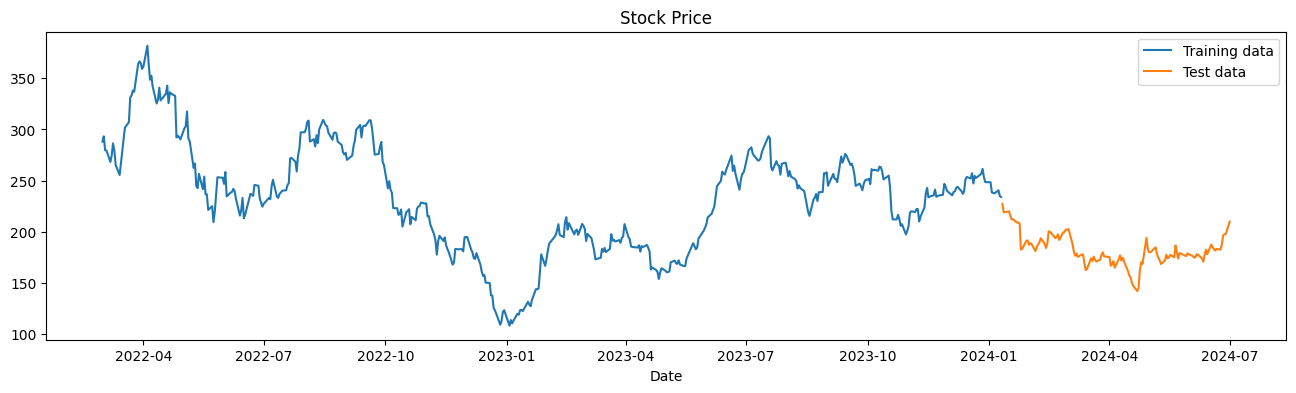

In [26]:
TSLA.plot()

In [27]:
tsla_lstm = StockModel(TSLA, LSTMHyperModel())
best_tsla_lstm = tsla_lstm.train_best_model()
best_tsla_lstm.summary()

Trial 20 Complete [00h 00m 08s]
val_loss: 0.003083544666878879

Best val_loss So Far: 0.001616707246284932
Total elapsed time: 00h 03m 06s


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        46,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,901 (183.21 KB)

 Trainable params: 46,901 (183.21 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
tsla_gru = StockModel(TSLA, GRUHyperModel())
best_tsla_gru = tsla_gru.train_best_model()
best_tsla_gru.summary()

Trial 20 Complete [00h 00m 09s]
val_loss: 0.003027195343747735

Best val_loss So Far: 0.000963283731834963
Total elapsed time: 00h 09m 40s


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30, 100)        │        35,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 30, 25)         │         9,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 25)             │         3,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,851 (190.82 KB)

 Trainable params: 48,851 (190.82 KB)

 Non-trainable params: 0 (0.00 B)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Root Mean Squared Error: 11.32 USD
Model Accuracy: 94.59%


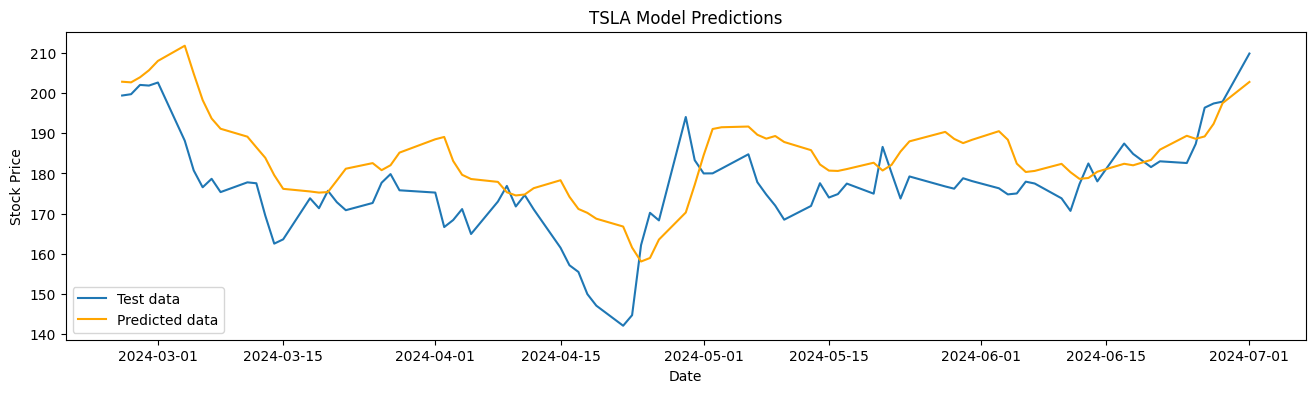

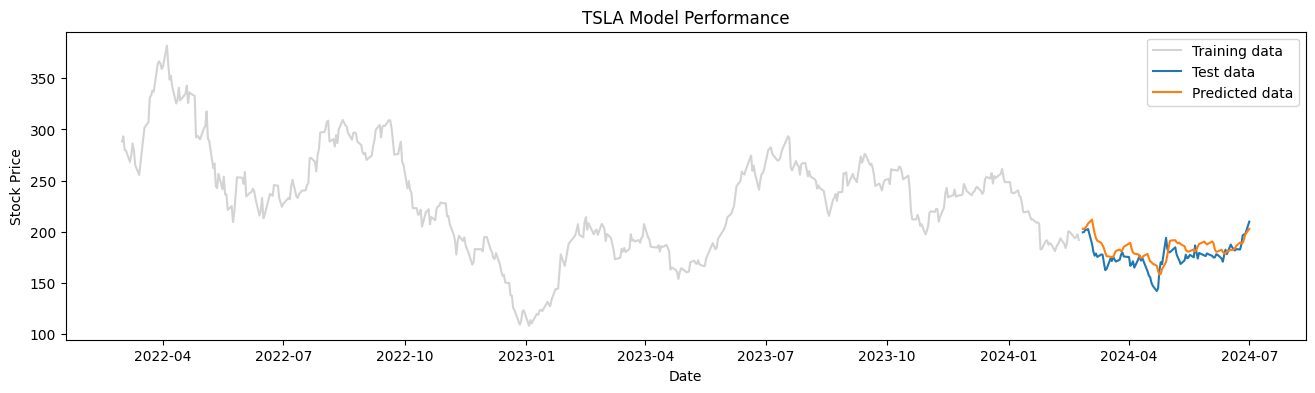

In [29]:
tsla_lstm.evaluate_model()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Root Mean Squared Error: 6.90 USD
Model Accuracy: 97.02%


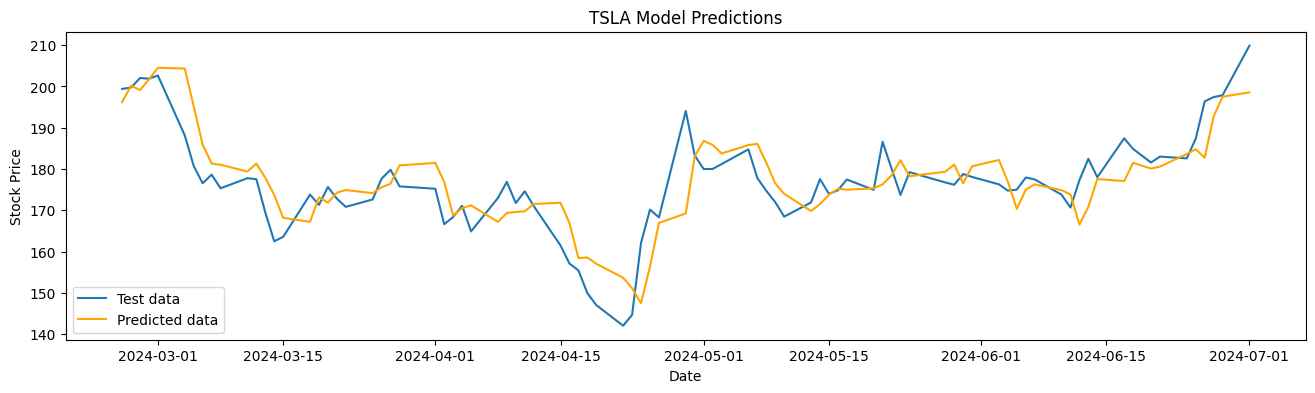

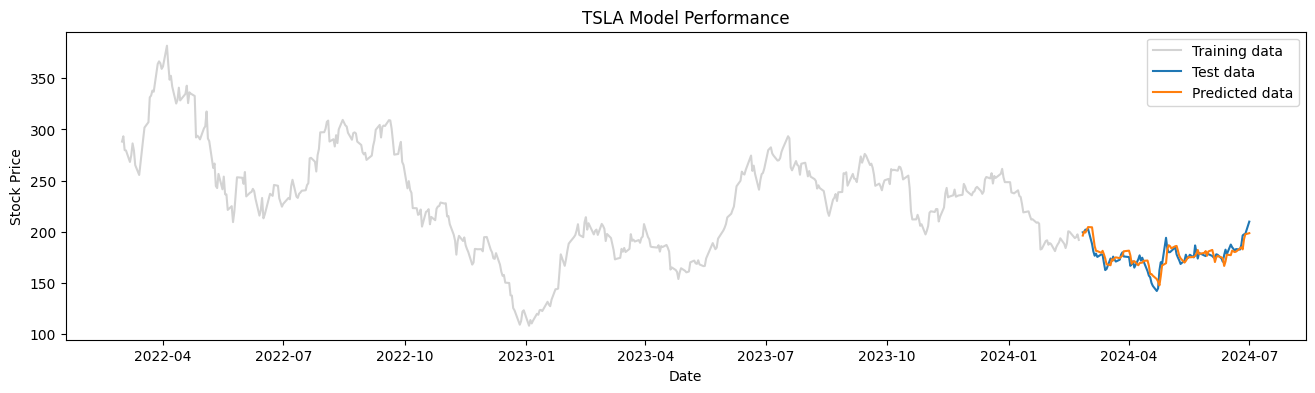

In [30]:
tsla_gru.evaluate_model()

## AAPL

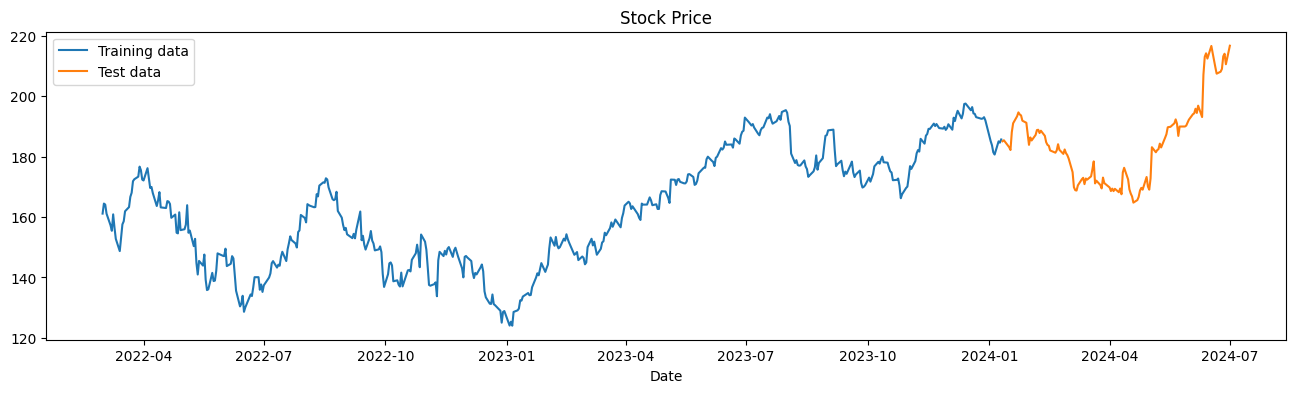

In [31]:
AAPL.plot()

In [32]:
aapl_lstm = StockModel(AAPL, LSTMHyperModel())
best_aapl_lstm = aapl_lstm.train_best_model()
best_aapl_lstm.summary()

Trial 20 Complete [00h 00m 12s]
val_loss: 0.003025678568519652

Best val_loss So Far: 0.002397135889623314
Total elapsed time: 00h 04m 04s


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 125)            │        71,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,126 (277.84 KB)

 Trainable params: 71,126 (277.84 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
aapl_gru = StockModel(AAPL, GRUHyperModel())
best_aapl_gru = aapl_gru.train_best_model()
best_aapl_gru.summary()

Trial 20 Complete [00h 00m 11s]
val_loss: 0.0024274277966469526

Best val_loss So Far: 0.0011515357182361186
Total elapsed time: 00h 04m 10s


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30, 150)        │        75,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 30, 50)         │        30,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 75)             │        28,575 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            76 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,551 (525.59 KB)

 Trainable params: 134,551 (525.59 KB)

 Non-trainable params: 0 (0.00 B)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Root Mean Squared Error: 5.71 USD
Model Accuracy: 97.59%


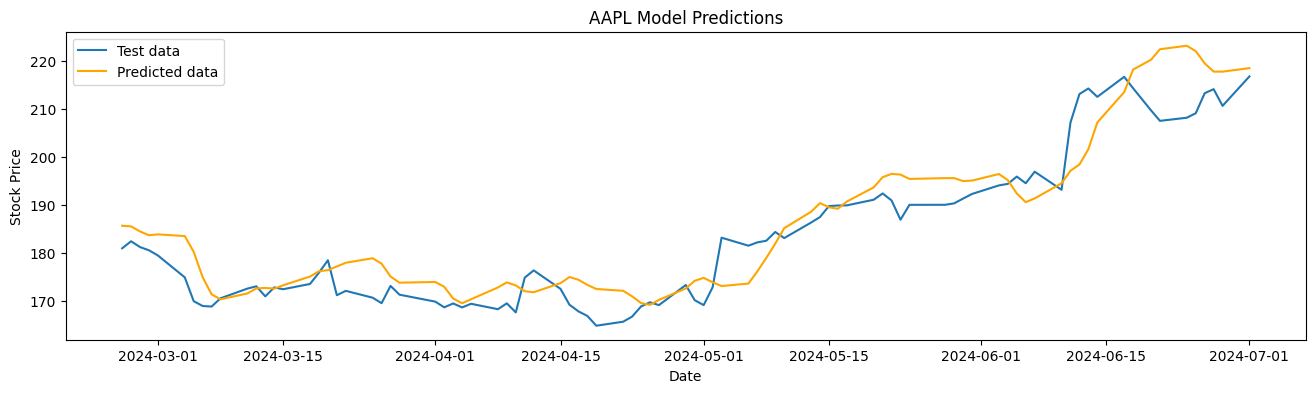

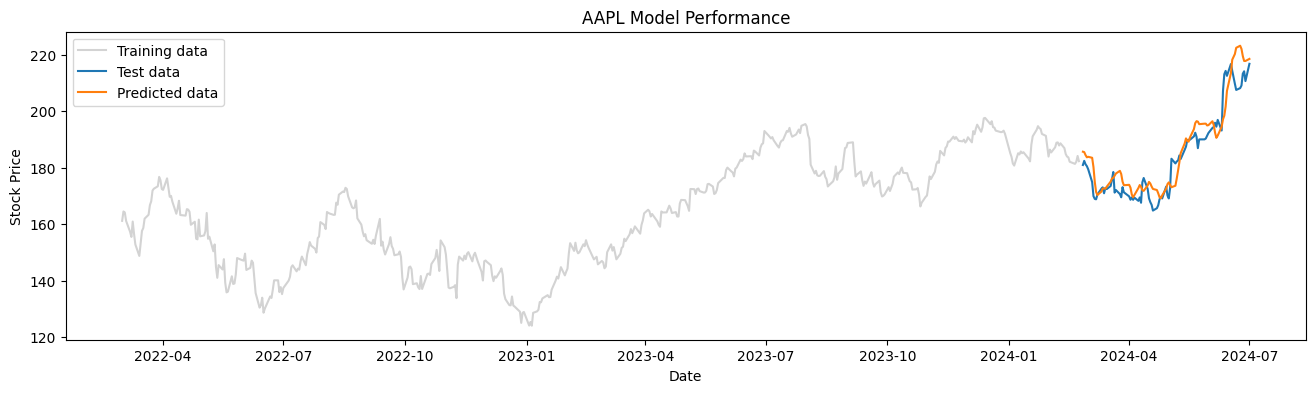

In [34]:
aapl_lstm.evaluate_model()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Root Mean Squared Error: 3.84 USD
Model Accuracy: 98.40%


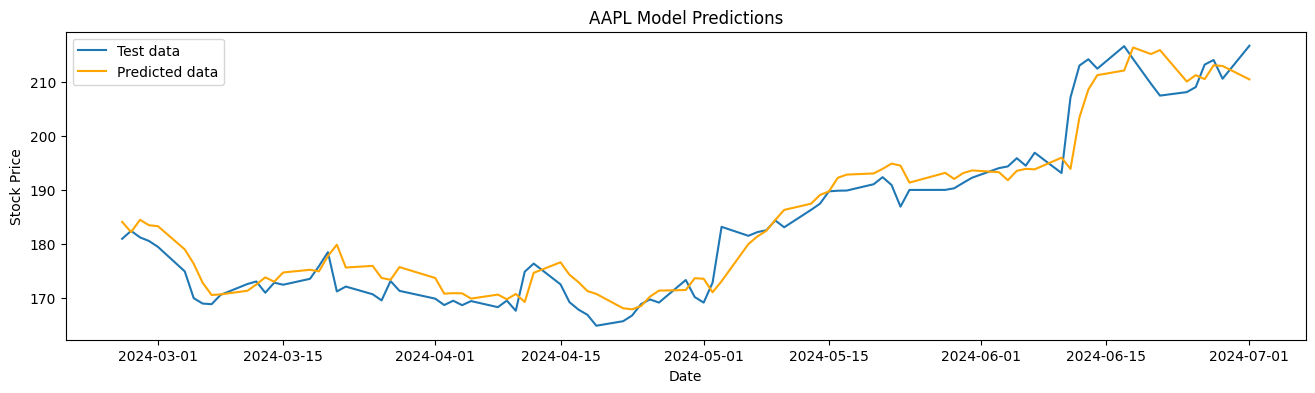

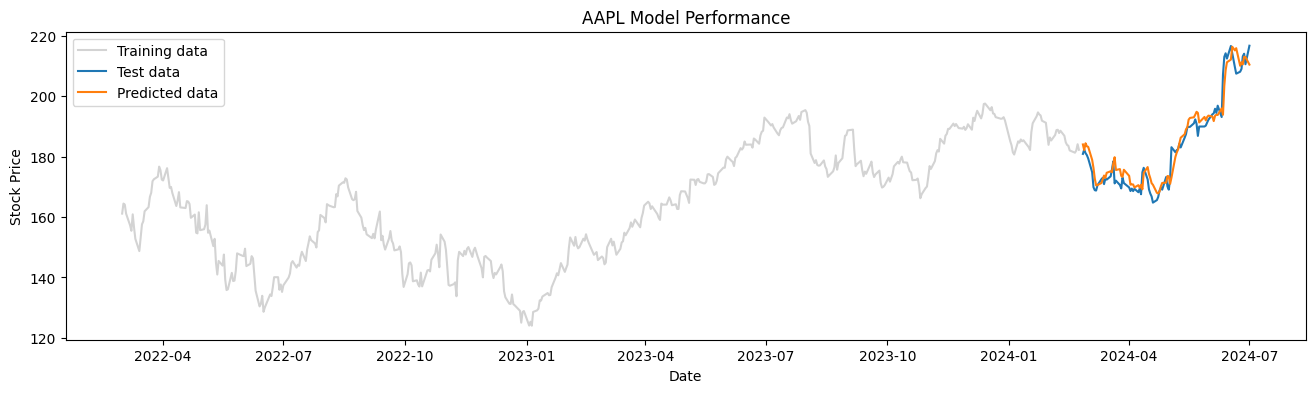

In [35]:
aapl_gru.evaluate_model()

## GOOG

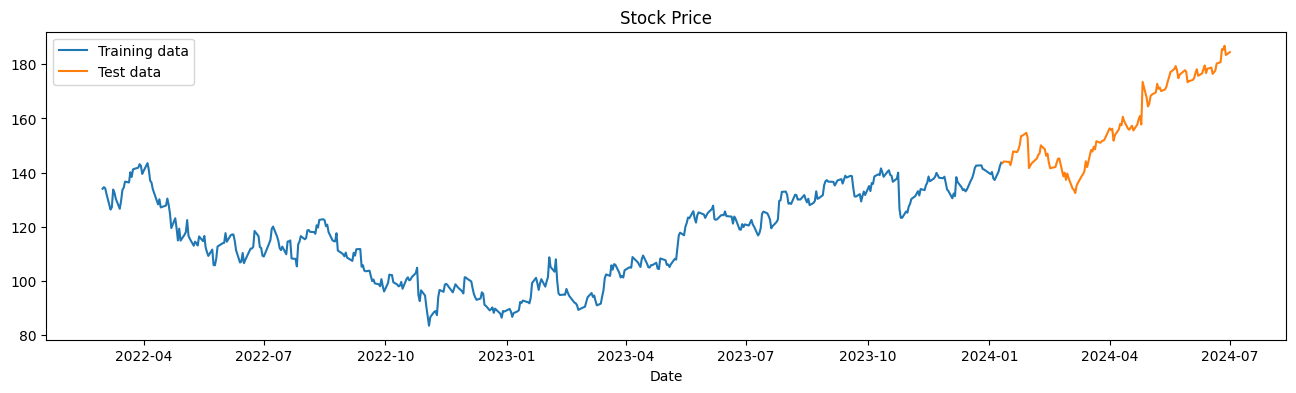

In [36]:
GOOG.plot()

In [51]:
goog_lstm = StockModel(GOOG, LSTMHyperModel())
best_goog_lstm = goog_lstm.train_best_model()
best_goog_lstm.summary()

Trial 20 Complete [00h 00m 16s]
val_loss: 0.004707953718025237

Best val_loss So Far: 0.0013135995832271874
Total elapsed time: 00h 05m 12s


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 150)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,351 (392.00 KB)

 Trainable params: 100,351 (392.00 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
goog_gru = StockModel(GOOG, GRUHyperModel())
best_goog_gru = goog_gru.train_best_model()
best_goog_gru.summary()

Reloading Tuner from models/GOOG/GRU/tuner0.json


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 25)             │         3,225 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,251 (12.70 KB)

 Trainable params: 3,251 (12.70 KB)

 Non-trainable params: 0 (0.00 B)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Root Mean Squared Error: 7.03 USD
Model Accuracy: 96.15%


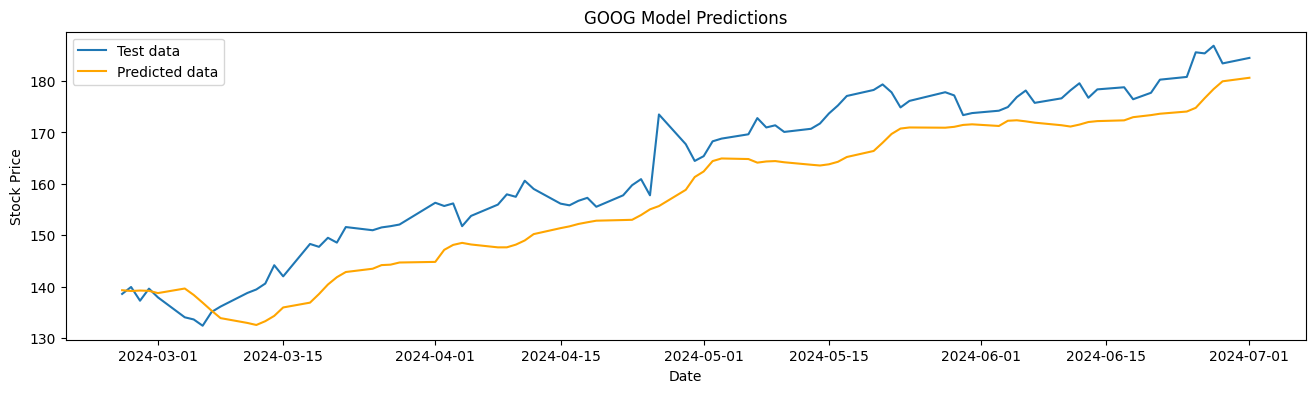

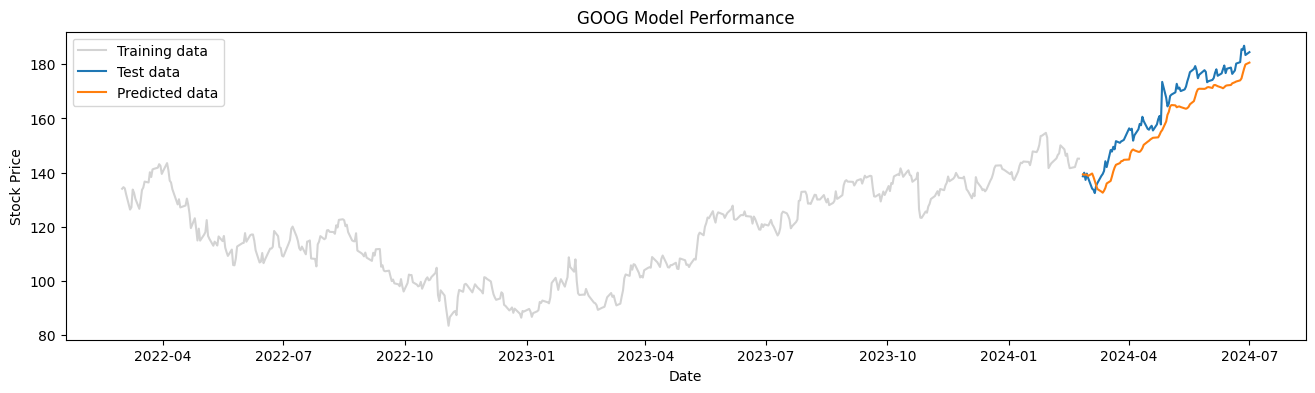

In [53]:
goog_lstm.evaluate_model()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Root Mean Squared Error: 3.35 USD
Model Accuracy: 98.42%


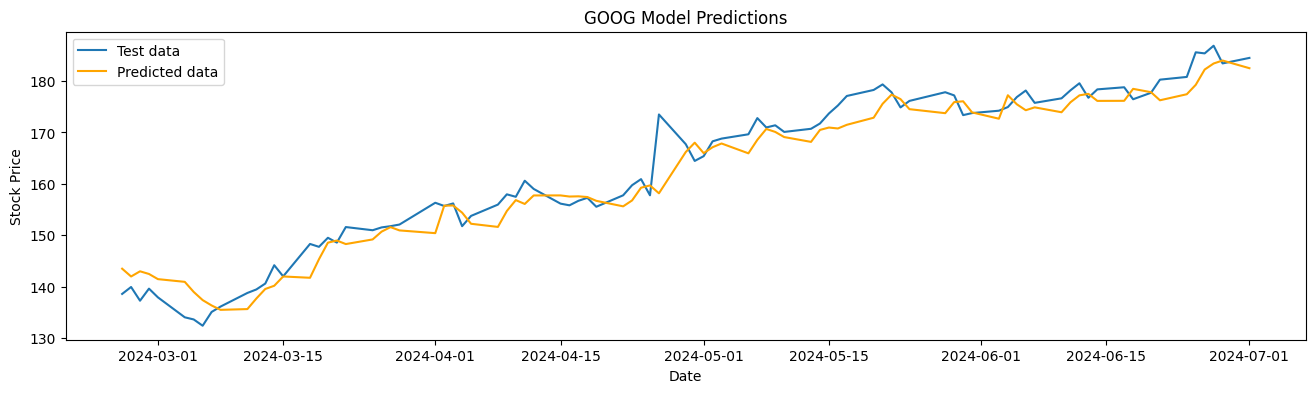

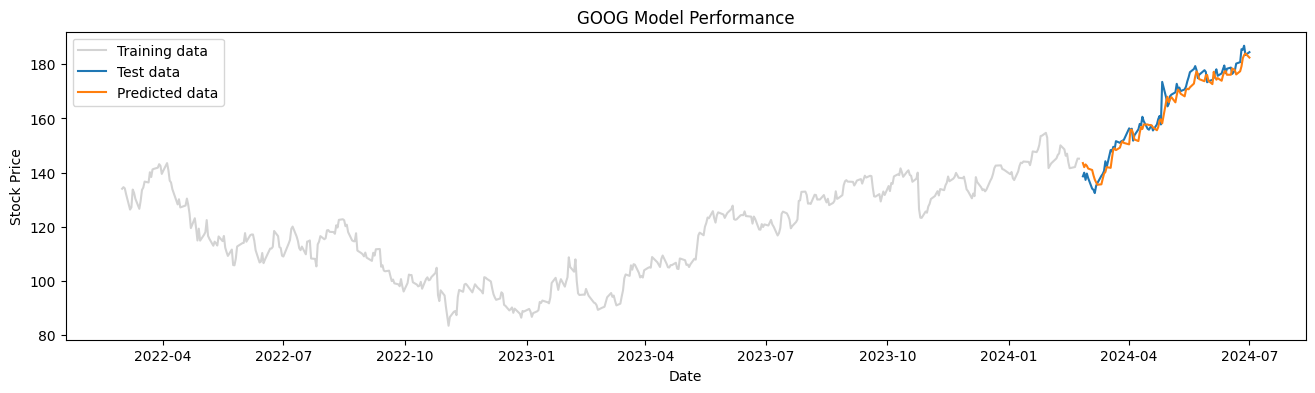

In [54]:
goog_gru.evaluate_model()

## Evaluation

In [57]:
models = dict(
    tsla_lstm = tsla_lstm, 
    tsla_gru = tsla_gru,
    aapl_lstm = aapl_lstm,
    aapl_gru = aapl_gru,
    goog_lstm = goog_lstm, 
    goog_gru = goog_gru,
)

results = pd.DataFrame()

for k, v in models.items():
    stock, model = k.split('_')
    params = v.best_hyperparameters
    accuracy = v.accuracy
    rmse = v.rmse
    
    data = pd.DataFrame(params, index=[len(results)])
    data['Model'] = model.upper()
    data['Stock'] = stock.upper()
    data['Accuracy'] = accuracy
    data['RMSE'] = rmse
    
    results = pd.concat([results, data], ignore_index=True)
    
results['num_layers'] = results['num_lstm_layers'].fillna(results['num_gru_layers'])
results['units_0'] = results['lstm_units_0'].fillna(results['gru_units_0'])
results['units_1'] = results['lstm_units_1'].fillna(results['gru_units_1'])
results['units_2'] = results['lstm_units_2'].fillna(results['gru_units_2'])
results.drop(['num_lstm_layers', 'num_gru_layers', 'lstm_units_0', 'gru_units_0',
             'lstm_units_1', 'gru_units_1', 'lstm_units_2', 'gru_units_2'], axis=1, inplace=True)

results = results[['Stock', 'Model', 'Accuracy', 'RMSE', 'num_layers', 'units_0', 'units_1', 'units_2', 
                    'optimizer', 'learning_rate']]

display(results)

,Stock,Model,Accuracy,RMSE,num_layers,units_0,units_1,units_2,optimizer,learning_rate
0,TSLA,LSTM,94.59,11.32,1.00,100.00,100.00,50.00,adam,0.01
1,TSLA,GRU,97.02,6.90,3.00,100.00,25.00,25.00,adam,0.01
2,AAPL,LSTM,97.59,5.71,1.00,125.00,50.00,75.00,adam,0.01
3,AAPL,GRU,98.40,3.84,3.00,150.00,50.00,75.00,adam,0.01
4,GOOG,LSTM,96.15,7.03,1.00,150.00,100.00,100.00,adam,0.00
5,GOOG,GRU,98.42,3.35,1.00,25.00,75.00,125.00,adam,0.01


In [61]:
results.to_csv('rnn-results.csv')

In [66]:
# !zip -r file.zip /kaggle/working